In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../src/')

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from dataloading import SpectrogramDataset
from torch.utils.data._utils.collate import default_collate

from torchsummary import summary
import matplotlib.pyplot as plt
plt.rcdefaults()

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from dataloading import repeat_channels

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=False),
    transforms.Lambda(repeat_channels),  # repeat grayscale image to 3 channels to match model input size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])
transform_eNetV2S = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((384, 384), antialias=False),
    transforms.Lambda(repeat_channels),  # repeat grayscale image to 3 channels to match model input size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

In [4]:
DATA_PATH = "../data/dataset_h5"
FILE_EXT = "h5"
WINDOW_SIZE = 200  # number of .512ms time steps per window
OVERLAP_FACTOR = 0.5  # overlap between consecutive windows

dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, window_size=WINDOW_SIZE,
                             overlap=OVERLAP_FACTOR, transform=transform)

# split the dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=default_collate, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=default_collate, num_workers=0)

#dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=default_collate, num_workers=0)

Processing dataset:   0%|          | 0/94 [00:00<?, ?it/s]

Last odd spectrogram slice shape: (800, 200)
Total number of windows = 2394
Number of unique IDs = 2394


In [5]:
import timm

# EfficientNetV2-S -- 20M params
#model = timm.create_model('tf_efficientnetv2_s', pretrained=True)

# EfficientNet-B0 -- 4M params
model = timm.create_model('efficientnet_b0', pretrained=True)

# replace classifier layer
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),  # output one value
    #nn.ReLU(),
    #nn.Linear(640, 1),
    #nn.Sigmoid()
)

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              SiLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 32, 112, 112]             288
          Identity-6         [-1, 32, 112, 112]               0
              SiLU-7         [-1, 32, 112, 112]               0
    BatchNormAct2d-8         [-1, 32, 112, 112]              64
            Conv2d-9              [-1, 8, 1, 1]             264
             SiLU-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             288
          Sigmoid-12             [-1, 32, 1, 1]               0
    SqueezeExcite-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 16, 1

In [6]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

criterion = nn.BCEWithLogitsLoss()  #pos_weight=torch.tensor([3.2]).to(device))  # binary Cross Entropy Loss with Logits
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 12
scheduler = CosineAnnealingWarmRestarts(optimizer,
                                        T_0=(len(train_loader.dataset) * num_epochs) // (train_loader.batch_size * 3),
                                        T_mult=1, verbose=False)

num_epochs = 5
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
)

In [7]:
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import precision_score, f1_score
import numpy as michayel


def compute_metrics(predicted_probs, reference, threshold=0.5):
    """
    Compute the accuracy and f1 score for binary classification.

    @param predicted_logits: float32 tensor of shape (batch size, 1) representing raw model outputs (logits).
    @param reference: int64 tensor of shape (batch size,) with the binary class labels (0 or 1).
    """
    # Convert probabilities to binary predictions (0 or 1)
    predicted_labels = predicted_probs > threshold

    # Convert tensors to numpy arrays for compatibility with sklearn metrics
    predicted_labels_np = predicted_labels.cpu().numpy()
    reference_np = reference.cpu().numpy()

    # Calculate precision, recall, and F1 score
    precision = precision_score(reference_np, predicted_labels_np, zero_division=0)
    f1 = f1_score(reference_np, predicted_labels_np, zero_division=0)

    return precision, f1


def train(model, train_loader, test_loader, optimizer, scheduler, criterion, device, n_epochs=1):
    device = torch.device(device)
    model.to(device)
    print(f"training on device '{device}'")

    losses = []
    f1s_test = []
    f1s_train = []

    for epoch in range(n_epochs):
        model.train()
        with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}') as tepoch:
            for batch in tepoch:
                x_batch = batch['window_odd']
                y_batch = batch['label']
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(x_batch)

                loss = criterion(y_pred, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                tepoch.set_postfix(loss=loss.item())

                losses.append(loss.item())

        model.eval()
        # evaluate on test set
        accuracies_test = []
        f1_test = []
        with tqdm(test_loader, unit='batch', desc='Evaluating') as tepoch:
            for batch in tepoch:
                x_batch = batch['window_odd']
                y_batch = batch['label']
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                with torch.no_grad():
                    prediction = torch.sigmoid(model(x_batch))
                    acc, f1 = compute_metrics(prediction, y_batch)
                    accuracies_test.append(acc)
                    f1_test.append(f1)

        f1s_test.append(michayel.mean(f1_test))

        # evaluate on train set
        accuracies_train = []
        f1_train = []
        with tqdm(train_loader, unit='batch', desc='Evaluating') as tepoch:
            for batch in tepoch:
                x_batch = batch['window_odd']
                y_batch = batch['label']
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                with torch.no_grad():
                    prediction = torch.sigmoid(model(x_batch))
                    acc, f1 = compute_metrics(prediction, y_batch)
                    accuracies_train.append(acc)
                    f1_train.append(f1)

        f1s_train.append(michayel.mean(f1_train))

        print(
            f"Epoch {epoch} | Train accuracy: {torch.tensor(accuracies_train).mean().item():.5f}, "
            f"f1: {torch.tensor(f1_train).mean().item():.5f}\n"
            f"           Test accuracy: {torch.tensor(accuracies_test).mean().item():.5f}, "
            f"f1: {torch.tensor(f1_test).mean().item():.5f}")

    plot_losses(losses)
    plot_f1(f1s_test, f1s_train)


def plot_losses(losses):
    plt.plot(losses, label='train')
    plt.title("loss")
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()


def plot_f1(f1s_test, f1s_train):
    plt.plot(f1s_test, label='test')
    plt.plot(f1s_train, label='train')
    plt.title("f1")
    plt.ylabel('f1')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()

training on device 'mps'


Epoch 0:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.88440, f1: 0.80276
        |  Test accuracy: 0.79500, f1: 0.68889


Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.97245, f1: 0.96639
        |  Test accuracy: 0.82577, f1: 0.74621


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.99640, f1: 0.99038
        |  Test accuracy: 0.88048, f1: 0.75198


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.99487, f1: 0.99618
        |  Test accuracy: 0.83392, f1: 0.81067


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.99595, f1: 0.99686
        |  Test accuracy: 0.87243, f1: 0.82039


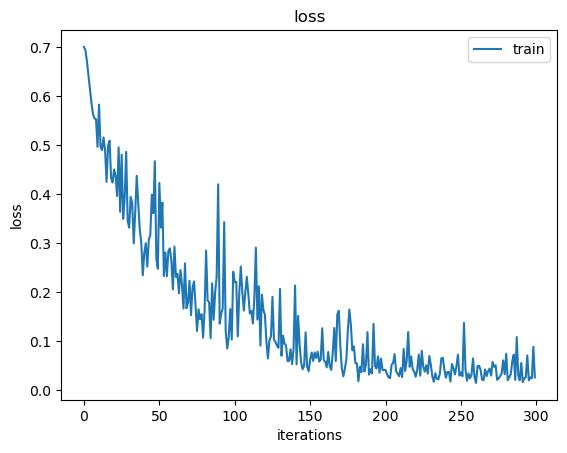

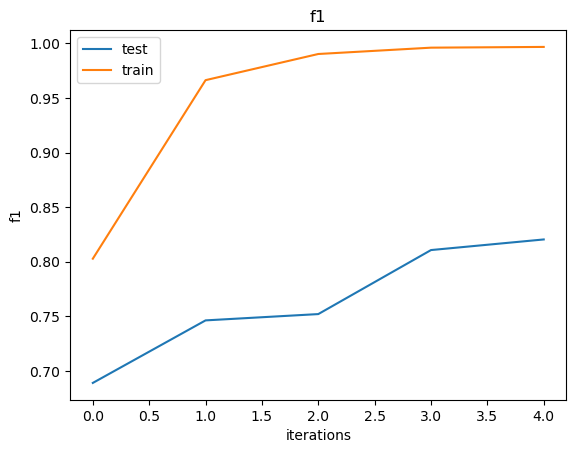

In [8]:
train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, n_epochs=5)